元の式：
$$\frac{dE_2(z)}{dz} = i \frac{\omega}{n_2c} E_1^2 d(z) \exp(-i\Delta kz)$$

定数部分を省略して簡略化：
$$\frac{dE_2(z)}{dz} = i d(z) \exp(-i\Delta kz)$$

周期分極反転構造では、$d(z)$は各ドメインで符号が変わります。ドメインkについて：
- $L^{(k)}$: k番目のドメインの幅
- $z^{(k)}$: k番目のドメインの始点（$z^{(k)} = \sum_{j=0}^{k-1} L^{(j)}$）
- $d^{(k)}$: k番目のドメインでの係数（通常は $(-1)^k d_0$、ここでは±1とする）

各ドメインkにおいて、$z \in [z^{(k)}, z^{(k)} + L^{(k)}]$の範囲で：
$$d(z) = d^{(k)}$$

はい、各ドメインの寄与を積分して足し合わせる形で表現できます。

各ドメインk内で$d(z) = d^{(k)}$（定数）なので、ドメインkにおける積分は：

$$\Delta E_2^{(k)} = \int_{z^{(k)}}^{z^{(k)}+L^{(k)}} i d^{(k)} \exp(-i\Delta k z) dz$$

これを計算すると：

$$\Delta E_2^{(k)} = i d^{(k)} \left[ \frac{\exp(-i\Delta k z)}{-i\Delta k} \right]_{z^{(k)}}^{z^{(k)}+L^{(k)}}$$

$$= \frac{d^{(k)}}{\Delta k} \left[ \exp(-i\Delta k (z^{(k)}+L^{(k)})) - \exp(-i\Delta k z^{(k)}) \right]$$

$$= \frac{d^{(k)}}{\Delta k} \exp(-i\Delta k z^{(k)}) \left[ \exp(-i\Delta k L^{(k)}) - 1 \right]$$

最終的な$E_2(z^{(N)})$は、初期条件$E_2(0) = 0$から始めて：

$$E_2(z^{(N)}) = \sum_{k=0}^{N-1} \frac{d^{(k)}}{\Delta k} \exp(-i\Delta k z^{(k)}) \left[ \exp(-i\Delta k L^{(k)}) - 1 \right]$$

ただし、$\Delta k = 0$の場合は別途考慮が必要で：
$$\Delta E_2^{(k)}|_{\Delta k=0} = i d^{(k)} L^{(k)}$$

与えられた式中の$\Delta k$を$2\Gamma$に置き換えた式を以下に示します。

---

$$E_2(z^{(N)}) = \sum_{k=0}^{N-1} \frac{d^{(k)}}{2\Gamma} \exp(-i2\Gamma z^{(k)}) \left[ \exp(-i2\Gamma L^{(k)}) - 1 \right]$$

ただし、$2\Gamma = 0$（つまり$\Gamma = 0$）の場合は別途考慮が必要で：

$$\Delta E_2^{(k)}|_{2\Gamma=0} = i d^{(k)} L^{(k)}$$

---

/workspaces/mictlan/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Noto Sans CJK JP.
  fig.canvas.print_figure(bytes_io, **kw)


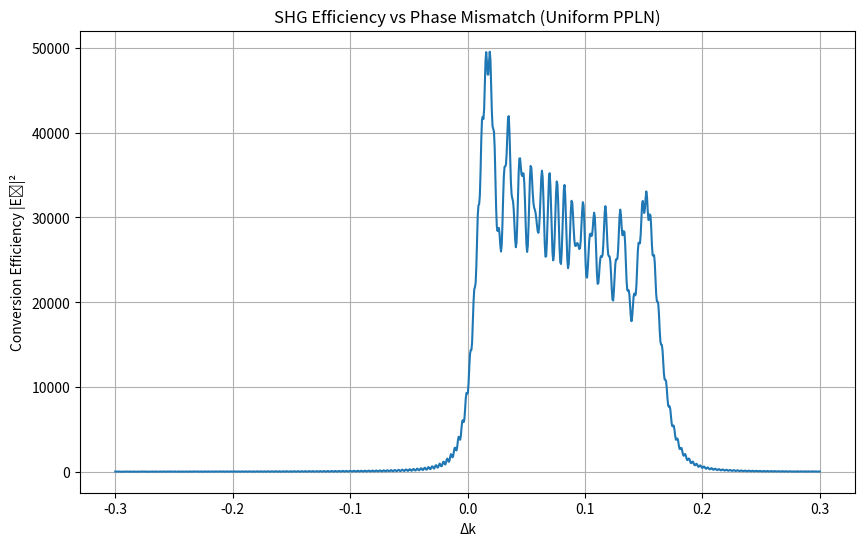

In [1]:
import jax.numpy as jnp
from jax import jit, vmap
import matplotlib.pyplot as plt


@jit
def solve_shg_analytical(domain_params, delta_k):
    """
    周期分極反転構造におけるSHGの解析解

    Args:
        domain_params: (num_domains, 2) array
                      各行は [L^(k), d^(k)]
        delta_k: 位相不整合パラメータ

    Returns:
        E2: 最終的なSHG振幅（複素数）
    """
    # ドメインの幅と係数を分離
    L = domain_params[:, 0]  # 各ドメインの幅
    d = domain_params[:, 1]  # 各ドメインの係数（±1）

    # 各ドメインの始点を計算
    z_start = jnp.concatenate([jnp.array([0.]), jnp.cumsum(L[:-1])])

    # delta_k = 0の場合の処理
    def zero_mismatch_case():
        # Δk=0の場合: ΔE2^(k) = i * d^(k) * L^(k)
        return 1j * jnp.sum(d * L)

    # delta_k ≠ 0の場合の処理
    def nonzero_mismatch_case():
        # 各ドメインの位相項
        phase_start = jnp.exp(-1j * delta_k * z_start)
        phase_length = jnp.exp(-1j * delta_k * L) - 1.0

        # 各ドメインの寄与
        contributions = (d / delta_k) * phase_start * phase_length

        return jnp.sum(contributions)

    # delta_kが0に近いかどうかで分岐
    return jnp.where(
        jnp.abs(delta_k) < 1e-10,
        zero_mismatch_case(),
        nonzero_mismatch_case()
    )


@jit
def compute_efficiency(domain_params, delta_k):
    """変換効率を計算（|E2|^2）"""
    E2 = solve_shg_analytical(domain_params, delta_k)
    return jnp.abs(E2) ** 2


# ベクトル化された関数（複数のdelta_kに対して並列計算）
solve_shg_vectorized = vmap(solve_shg_analytical, in_axes=(None, 0))
compute_efficiency_vectorized = vmap(compute_efficiency, in_axes=(None, 0))


# 2次元メッシュグリッド用の関数（異なる構造とdelta_kの組み合わせ）
@jit
def compute_efficiency_2d(domain_params_list, delta_k_array):
    """
    複数の構造と複数のdelta_kの組み合わせに対して効率を計算

    Args:
        domain_params_list: (num_structures, num_domains, 2) array
        delta_k_array: (num_delta_k,) array

    Returns:
        efficiency: (num_structures, num_delta_k) array
    """
    # 各構造に対してベクトル化
    compute_for_structure = vmap(
        compute_efficiency_vectorized, in_axes=(0, None))
    return compute_for_structure(domain_params_list, delta_k_array)


# テスト用の構造生成関数
def create_uniform_ppln(num_domains, period, duty_cycle=0.5):
    """
    均一な周期分極反転構造を生成

    Args:
        num_domains: ドメイン数
        period: 周期（2ドメインで1周期）
        duty_cycle: デューティサイクル（0-1）

    Returns:
        domain_params: (num_domains, 2) array
    """
    domain_params = jnp.zeros((num_domains, 2))

    for i in range(num_domains):
        if i % 2 == 0:
            domain_params = domain_params.at[i, 0].set(period * duty_cycle)
            domain_params = domain_params.at[i, 1].set(1.0)
        else:
            domain_params = domain_params.at[i, 0].set(
                period * (1 - duty_cycle))
            domain_params = domain_params.at[i, 1].set(-1.0)

    return domain_params


def create_chirped_ppln(num_domains, period_start, period_end, duty_cycle=0.5):
    """
    チャープ型周期分極反転構造を生成

    Args:
        num_domains: ドメイン数
        period_start: 開始周期
        period_end: 終了周期
        duty_cycle: デューティサイクル

    Returns:
        domain_params: (num_domains, 2) array
    """
    num_periods = num_domains // 2
    periods = jnp.linspace(period_start, period_end, num_periods)

    domain_params = jnp.zeros((num_domains, 2))

    for i in range(num_domains):
        period_idx = i // 2
        if period_idx < len(periods):
            period = periods[period_idx]
            if i % 2 == 0:
                domain_params = domain_params.at[i, 0].set(period * duty_cycle)
                domain_params = domain_params.at[i, 1].set(1.0)
            else:
                domain_params = domain_params.at[i, 0].set(
                    period * (1 - duty_cycle))
                domain_params = domain_params.at[i, 1].set(-1.0)

    return domain_params


if __name__ == "__main__":
    Lambda = 7.2
    # uniform_ppln = create_uniform_ppln(600, period=7.2, duty_cycle=0.5)
    uniform_ppln = create_chirped_ppln(
        600, period_start=Lambda, period_end=6.0, duty_cycle=0.5)

    delta_k_range = jnp.linspace(-0.3, 0.3, 1000)
    K = 2*jnp.pi / Lambda
    efficiency = compute_efficiency_vectorized(uniform_ppln, delta_k_range + K)

    plt.figure(figsize=(10, 6))
    plt.plot(delta_k_range, efficiency)
    plt.xlabel('Δk')
    plt.ylabel('Conversion Efficiency |E₂|²')
    plt.title('SHG Efficiency vs Phase Mismatch (Uniform PPLN)')
    plt.grid(True)
    plt.show()

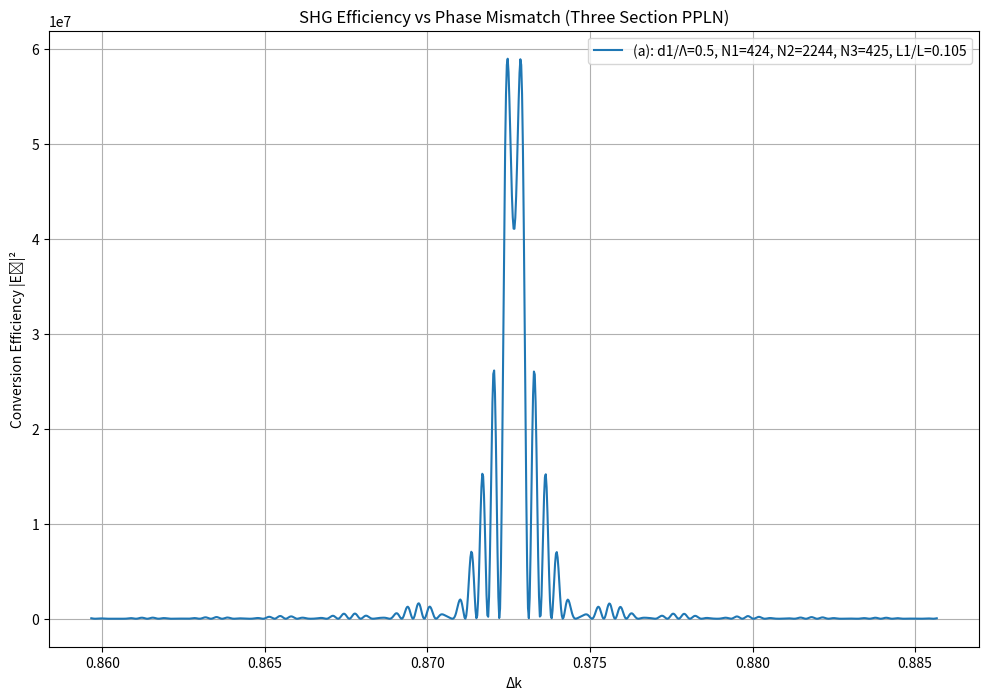

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt


def create_three_section_ppln_with_defects(N1, N2, N3, period, delta1, delta2):
    """
    3セクションPPLN構造を生成（中央セクションに2つの欠陥あり）
    """
    half_period = period / 2.0
    domains = []

    # セクション1
    for i in range(N1):
        domains.append([half_period, 1.0])
        domains.append([half_period, -1.0])

    # オフセット1
    domains.append([delta1, 1.0])

    # セクション2
    for i in range(N2):
        domains.append([half_period, 1.0])
        domains.append([half_period, -1.0])

    # オフセット2
    domains.append([delta2, 1.0])

    # セクション3
    for i in range(N3):
        domains.append([half_period, 1.0])
        domains.append([half_period, -1.0])

    return jnp.array(domains)


# 条件設定
params_array = jnp.array([
    [0.5, 424, 2244, 425, 0.105],   # a
    # [0.5, 21, 158, 21, 0.105],   # a
    # [0.4, 67, 366, 67, 0.134],   # b
    # [0.35, 75, 269, 75, 0.179]   # c
])
labels = ['a', 'b', 'c']

period = 7.2
K = 2*jnp.pi/period
delta_k_range = jnp.linspace(-0.013, 0.013, 1000) + K

# 個別に効率計算してプロット
plt.figure(figsize=(12, 8))
for i, (label, params) in enumerate(zip(labels, params_array)):
    d1_A, N1, N2, N3, L1_L = params

    # 構造生成
    delta1 = period * d1_A
    delta2 = period - delta1
    structure = create_three_section_ppln_with_defects(
        int(N1), int(N2), int(N3), period, delta1, delta2)

    # 効率計算
    efficiency = compute_efficiency_vectorized(structure, delta_k_range)

    plt.plot(delta_k_range, efficiency,
             label=f'({label}): d1/Λ={d1_A}, N1={int(N1)}, N2={int(N2)}, N3={int(N3)}, L1/L={L1_L:.3f}')

plt.xlabel('Δk')
plt.ylabel('Conversion Efficiency |E₂|²')
plt.title('SHG Efficiency vs Phase Mismatch (Three Section PPLN)')
plt.legend()
plt.grid(True)
plt.show()

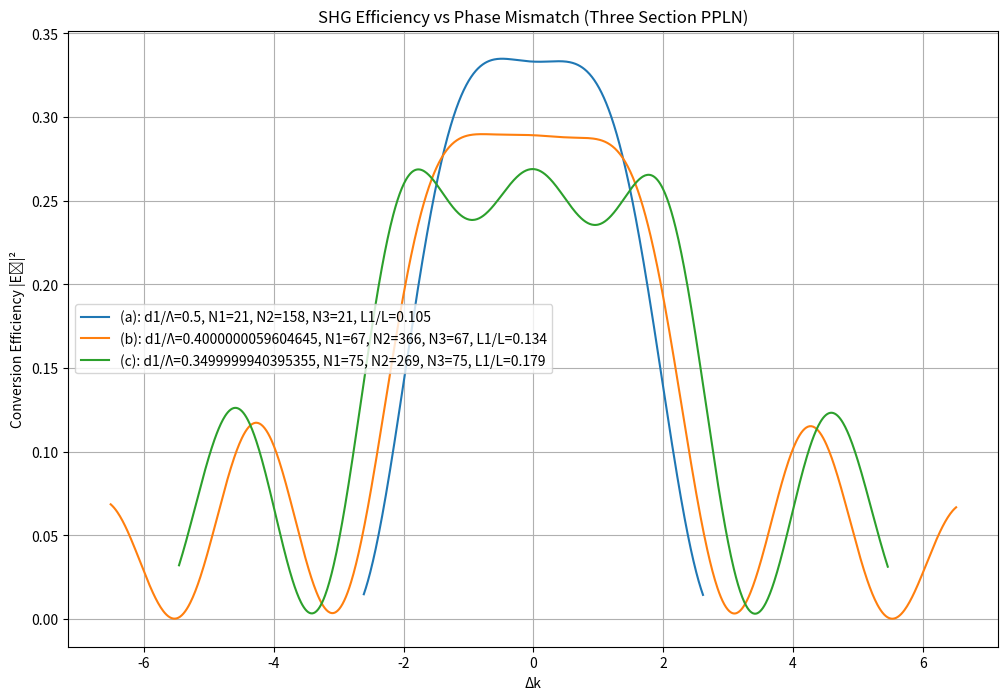

In [3]:
# 条件設定
params_array = jnp.array([
    [0.5, 21, 158, 21, 0.105],   # a
    [0.4, 67, 366, 67, 0.134],   # b
    [0.35, 75, 269, 75, 0.179]   # c
])
labels = ['a', 'b', 'c']

period = 3.23
K = 2*jnp.pi/period
delta_k_range = jnp.linspace(-0.013, 0.013, 1000)

# 個別に効率計算してプロット
plt.figure(figsize=(12, 8))
for i, (label, params) in enumerate(zip(labels, params_array)):
    d1_A, N1, N2, N3, L1_L = params

    # 構造生成
    delta1 = period * d1_A
    delta2 = period - delta1
    structure = create_three_section_ppln_with_defects(
        int(N1), int(N2), int(N3), period, delta1, delta2)

    # 効率計算
    efficiency = compute_efficiency_vectorized(structure, delta_k_range + K)

    # 同じ全長の通常のQPM構造を生成（位相シフトなし）
    num_periods_uniform = int(N1+N2+N3+1)
    uniform_structure = create_uniform_ppln(
        num_periods_uniform * 2, period, duty_cycle=0.5)

    efficiency_uniform = compute_efficiency_vectorized(
        uniform_structure, delta_k_range + K)

    # 変換効率と位相不整合を両方規格化して重ねて表示
    plt.plot(delta_k_range * num_periods_uniform, efficiency/jnp.max(efficiency_uniform),
             label=f'({label}): d1/Λ={d1_A}, N1={int(N1)}, N2={int(N2)}, N3={int(N3)}, L1/L={L1_L:.3f}')

plt.xlabel('Δk')
plt.ylabel('Conversion Efficiency |E₂|²')
plt.title('SHG Efficiency vs Phase Mismatch (Three Section PPLN)')
plt.legend()
plt.grid(True)
plt.show()

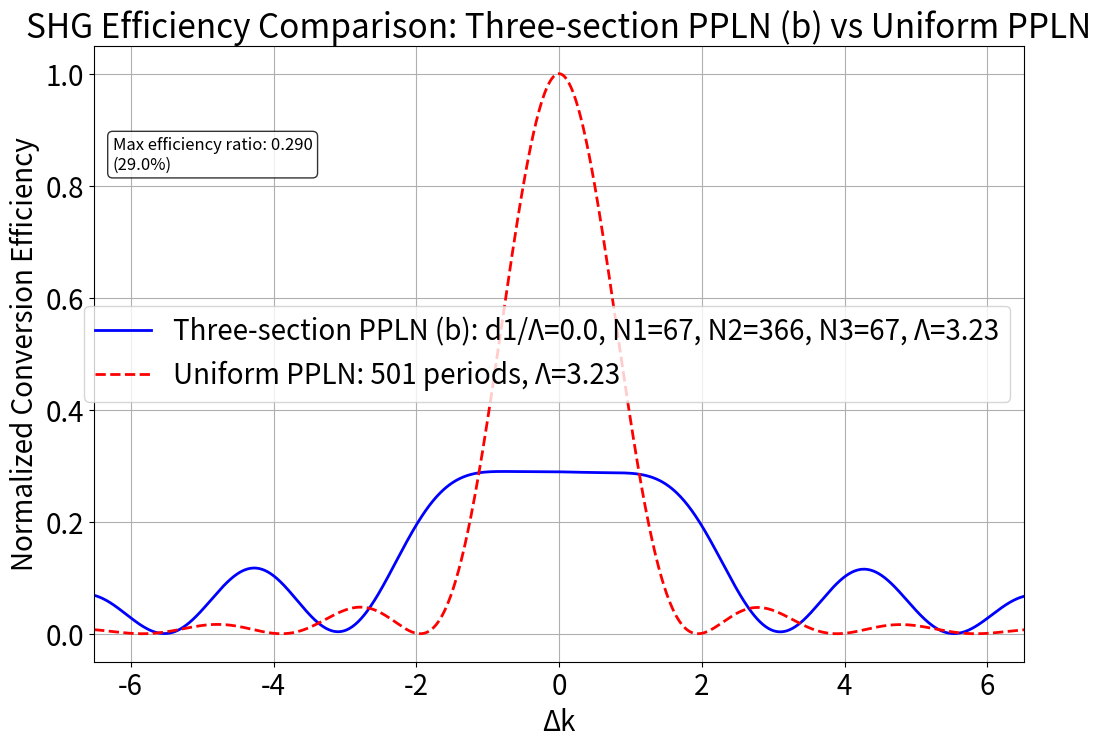

Three-section PPLN max efficiency: 307483.375000
Uniform PPLN max efficiency: 1061281.000000
Efficiency ratio (three-section/uniform): 0.290
Efficiency reduction: 71.0%


In [4]:
# 条件設定
params_array = jnp.array([
    [0.5, 21, 158, 21, 0.105],   # a
    [0.4, 67, 366, 67, 0.134],   # b
    [0.35, 75, 269, 75, 0.179]   # c
])
labels = ['a', 'b', 'c']

period = 3.23
K = 2*jnp.pi/period
delta_k_range = jnp.linspace(-0.013, 0.013, 1000)

# bの条件のみを抽出
b_index = 1
b_params = params_array[b_index]
d1_A, N1, N2, N3, L1_L = b_params

# b条件の構造生成
delta1 = period * d1_A
delta2 = period - delta1
structure_b = create_three_section_ppln_with_defects(
    int(N1), int(N2), int(N3), period, delta1, delta2)

# b条件の効率計算
efficiency_b = compute_efficiency_vectorized(structure_b, delta_k_range + K)

# 同じ全長の通常のQPM構造を生成（位相シフトなし）
num_periods_uniform = int(N1+N2+N3+1)
uniform_structure = create_uniform_ppln(
    num_periods_uniform * 2, period, duty_cycle=0.5)

efficiency_uniform = compute_efficiency_vectorized(
    uniform_structure, delta_k_range + K)

# プロット
plt.figure(figsize=(12, 8))

plt.rcParams.update({'font.size': 20})
# b条件をプロット
plt.plot(delta_k_range * num_periods_uniform, efficiency_b/jnp.max(efficiency_uniform),
         label=f'Three-section PPLN (b): d1/Λ={int(d1_A)/10}, N1={int(N1)}, N2={int(N2)}, N3={int(N3)}, Λ={period}', 
         linewidth=2, color='blue')

# uniform版をプロット
plt.plot(delta_k_range * num_periods_uniform, efficiency_uniform/jnp.max(efficiency_uniform),
         label=f'Uniform PPLN: {num_periods_uniform} periods, Λ={period}', 
         linewidth=2, color='red', linestyle='--')

# 最大効率の比較を表示
max_eff_b = jnp.max(efficiency_b)
max_eff_uniform = jnp.max(efficiency_uniform)
efficiency_ratio = max_eff_b / max_eff_uniform

plt.text(0.02, 0.8, f'Max efficiency ratio: {efficiency_ratio:.3f}\n({efficiency_ratio*100:.1f}%)', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.xlabel('Δk')
plt.ylabel('Normalized Conversion Efficiency')
plt.title('SHG Efficiency Comparison: Three-section PPLN (b) vs Uniform PPLN')
plt.legend()
plt.grid(True)
plt.xlim(delta_k_range[0] * num_periods_uniform, delta_k_range[-1] * num_periods_uniform)
plt.show()

print(f"Three-section PPLN max efficiency: {max_eff_b:.6f}")
print(f"Uniform PPLN max efficiency: {max_eff_uniform:.6f}")
print(f"Efficiency ratio (three-section/uniform): {efficiency_ratio:.3f}")
print(f"Efficiency reduction: {(1-efficiency_ratio)*100:.1f}%")